In [1]:
from hlm.hierarchical.svcp import SVCP
import pysal as ps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

hlm/abstracts.py:8: UserWarning: The `dill` module is required to use the sqlite backend and was not found.
  from .sqlite import head_to_sql, start_sql
/home/ljw/anaconda3/envs/py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
side = np.arange(0,10,1)
grid = np.tile(side, 10)

In [3]:
beta1 = grid.reshape(10,10)
beta2 = np.fliplr(beta1).T

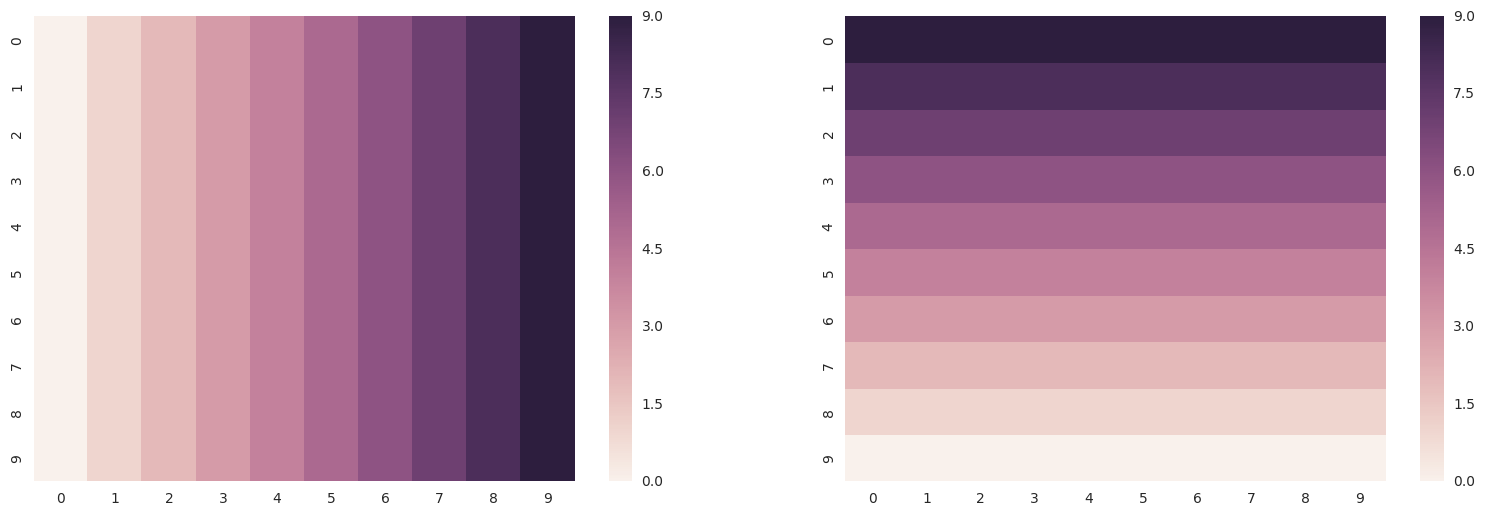

In [4]:
fig, ax = plt.subplots(1,2, figsize=(12*1.6, 6))
sns.heatmap(beta1, ax=ax[0])
sns.heatmap(beta2, ax=ax[1])
plt.show()

In [5]:
x1, x2 = np.random.normal(0,1,size=(100,2)).T

In [6]:
x1 = x1.reshape(100,1)
x2 = x2.reshape(100,1)

In [7]:
flat_beta1 = beta1.flatten().reshape(100,1)
flat_beta2 = beta2.flatten().reshape(100,1)

In [8]:
y = x1 * flat_beta1 + x2 * flat_beta2 + np.random.normal(0,1,size=(100,1))

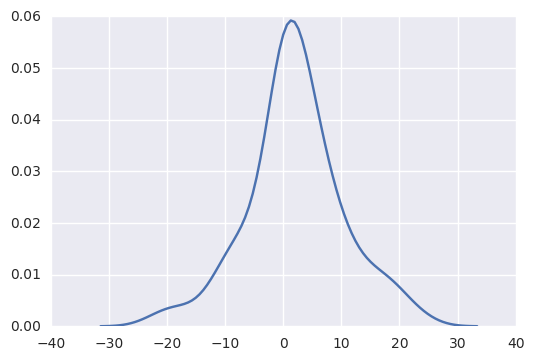

In [9]:
sns.kdeplot(y.flatten())

In [10]:
positions = np.array(list(zip(flat_beta1.flatten(), flat_beta2.flatten())))

In [11]:
X = np.hstack((x1, x2))

In [12]:
import time as t

In [13]:
m = SVCP(y, X, positions, n_samples=0)
m.state.Phi = 25
start = t.time()
m.sample(5000)
end = t.time() - start
print('{} seconds elapsed'.format(end))

42.9362401962 seconds elapsed


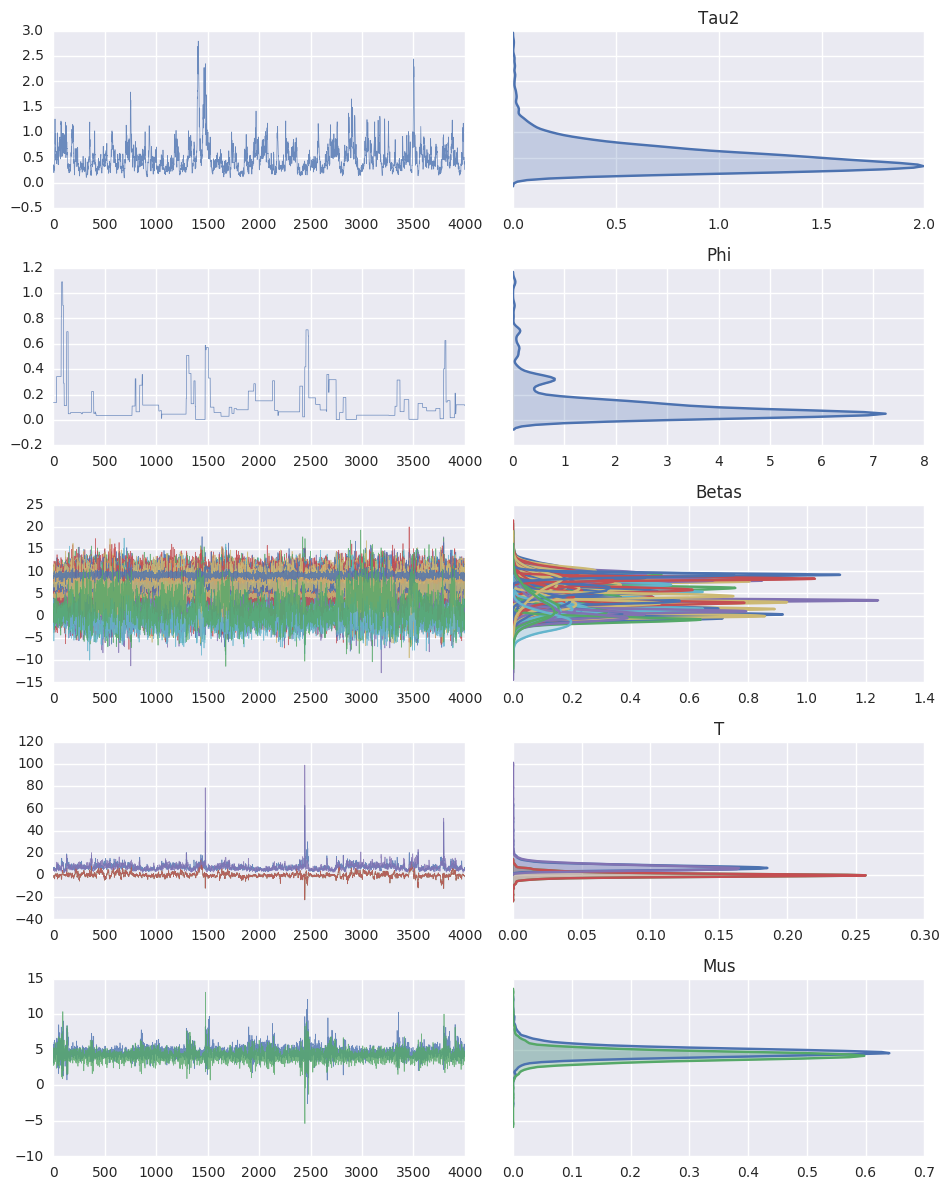

In [14]:
m.trace.plot(burn=1000)
plt.tight_layout()
plt.show()

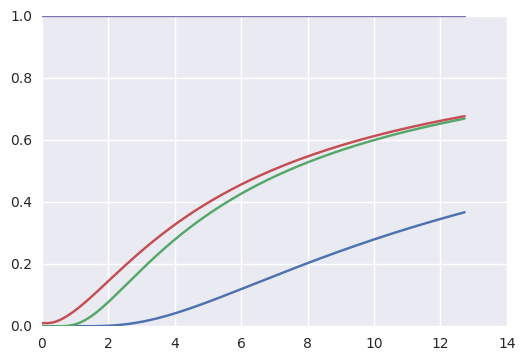

In [15]:
plt.plot(np.linspace(.001,1,num=1000)*m.state.max_dist, 
         [np.min(np.exp(-m.state.pwds/x)) for x in np.linspace(.001,1,num=1000)])
plt.plot(np.linspace(.001,1,num=1000)*m.state.max_dist, 
         [np.median(np.exp(-m.state.pwds/x)) for x in np.linspace(.001,1,num=1000)])
plt.plot(np.linspace(.001,1,num=1000)*m.state.max_dist, 
         [np.mean(np.exp(-m.state.pwds/x)) for x in np.linspace(.001,1,num=1000)])
plt.plot(np.linspace(.001,1,num=1000)*m.state.max_dist, 
         [np.max(np.exp(-m.state.pwds/x)) for x in np.linspace(.001,1,num=1000)])

In [16]:
m.state.max_dist

12.727922061357855

In [19]:
est_b1 = np.hstack(m.trace['Betas', ::2])
est_b2 = np.hstack(m.trace['Betas', 1::2])

In [20]:
import pandas as pd

In [21]:
df = pd.DataFrame.from_dict(m.trace.chains[0])

In [22]:
np.hstack(m.trace['Phi']).shape

(5000,)

In [23]:
np.stack(m.trace['T'], axis=2).shape

(2, 2, 5000)

In [24]:
np.stack(m.trace['Betas'], axis=2).dump('tst')

In [25]:
est_b1 = np.asarray(m.trace['Betas']).mean(axis=2).T[::2]
est_b2 = np.asarray(m.trace['Betas']).mean(axis=2).T[1::2]

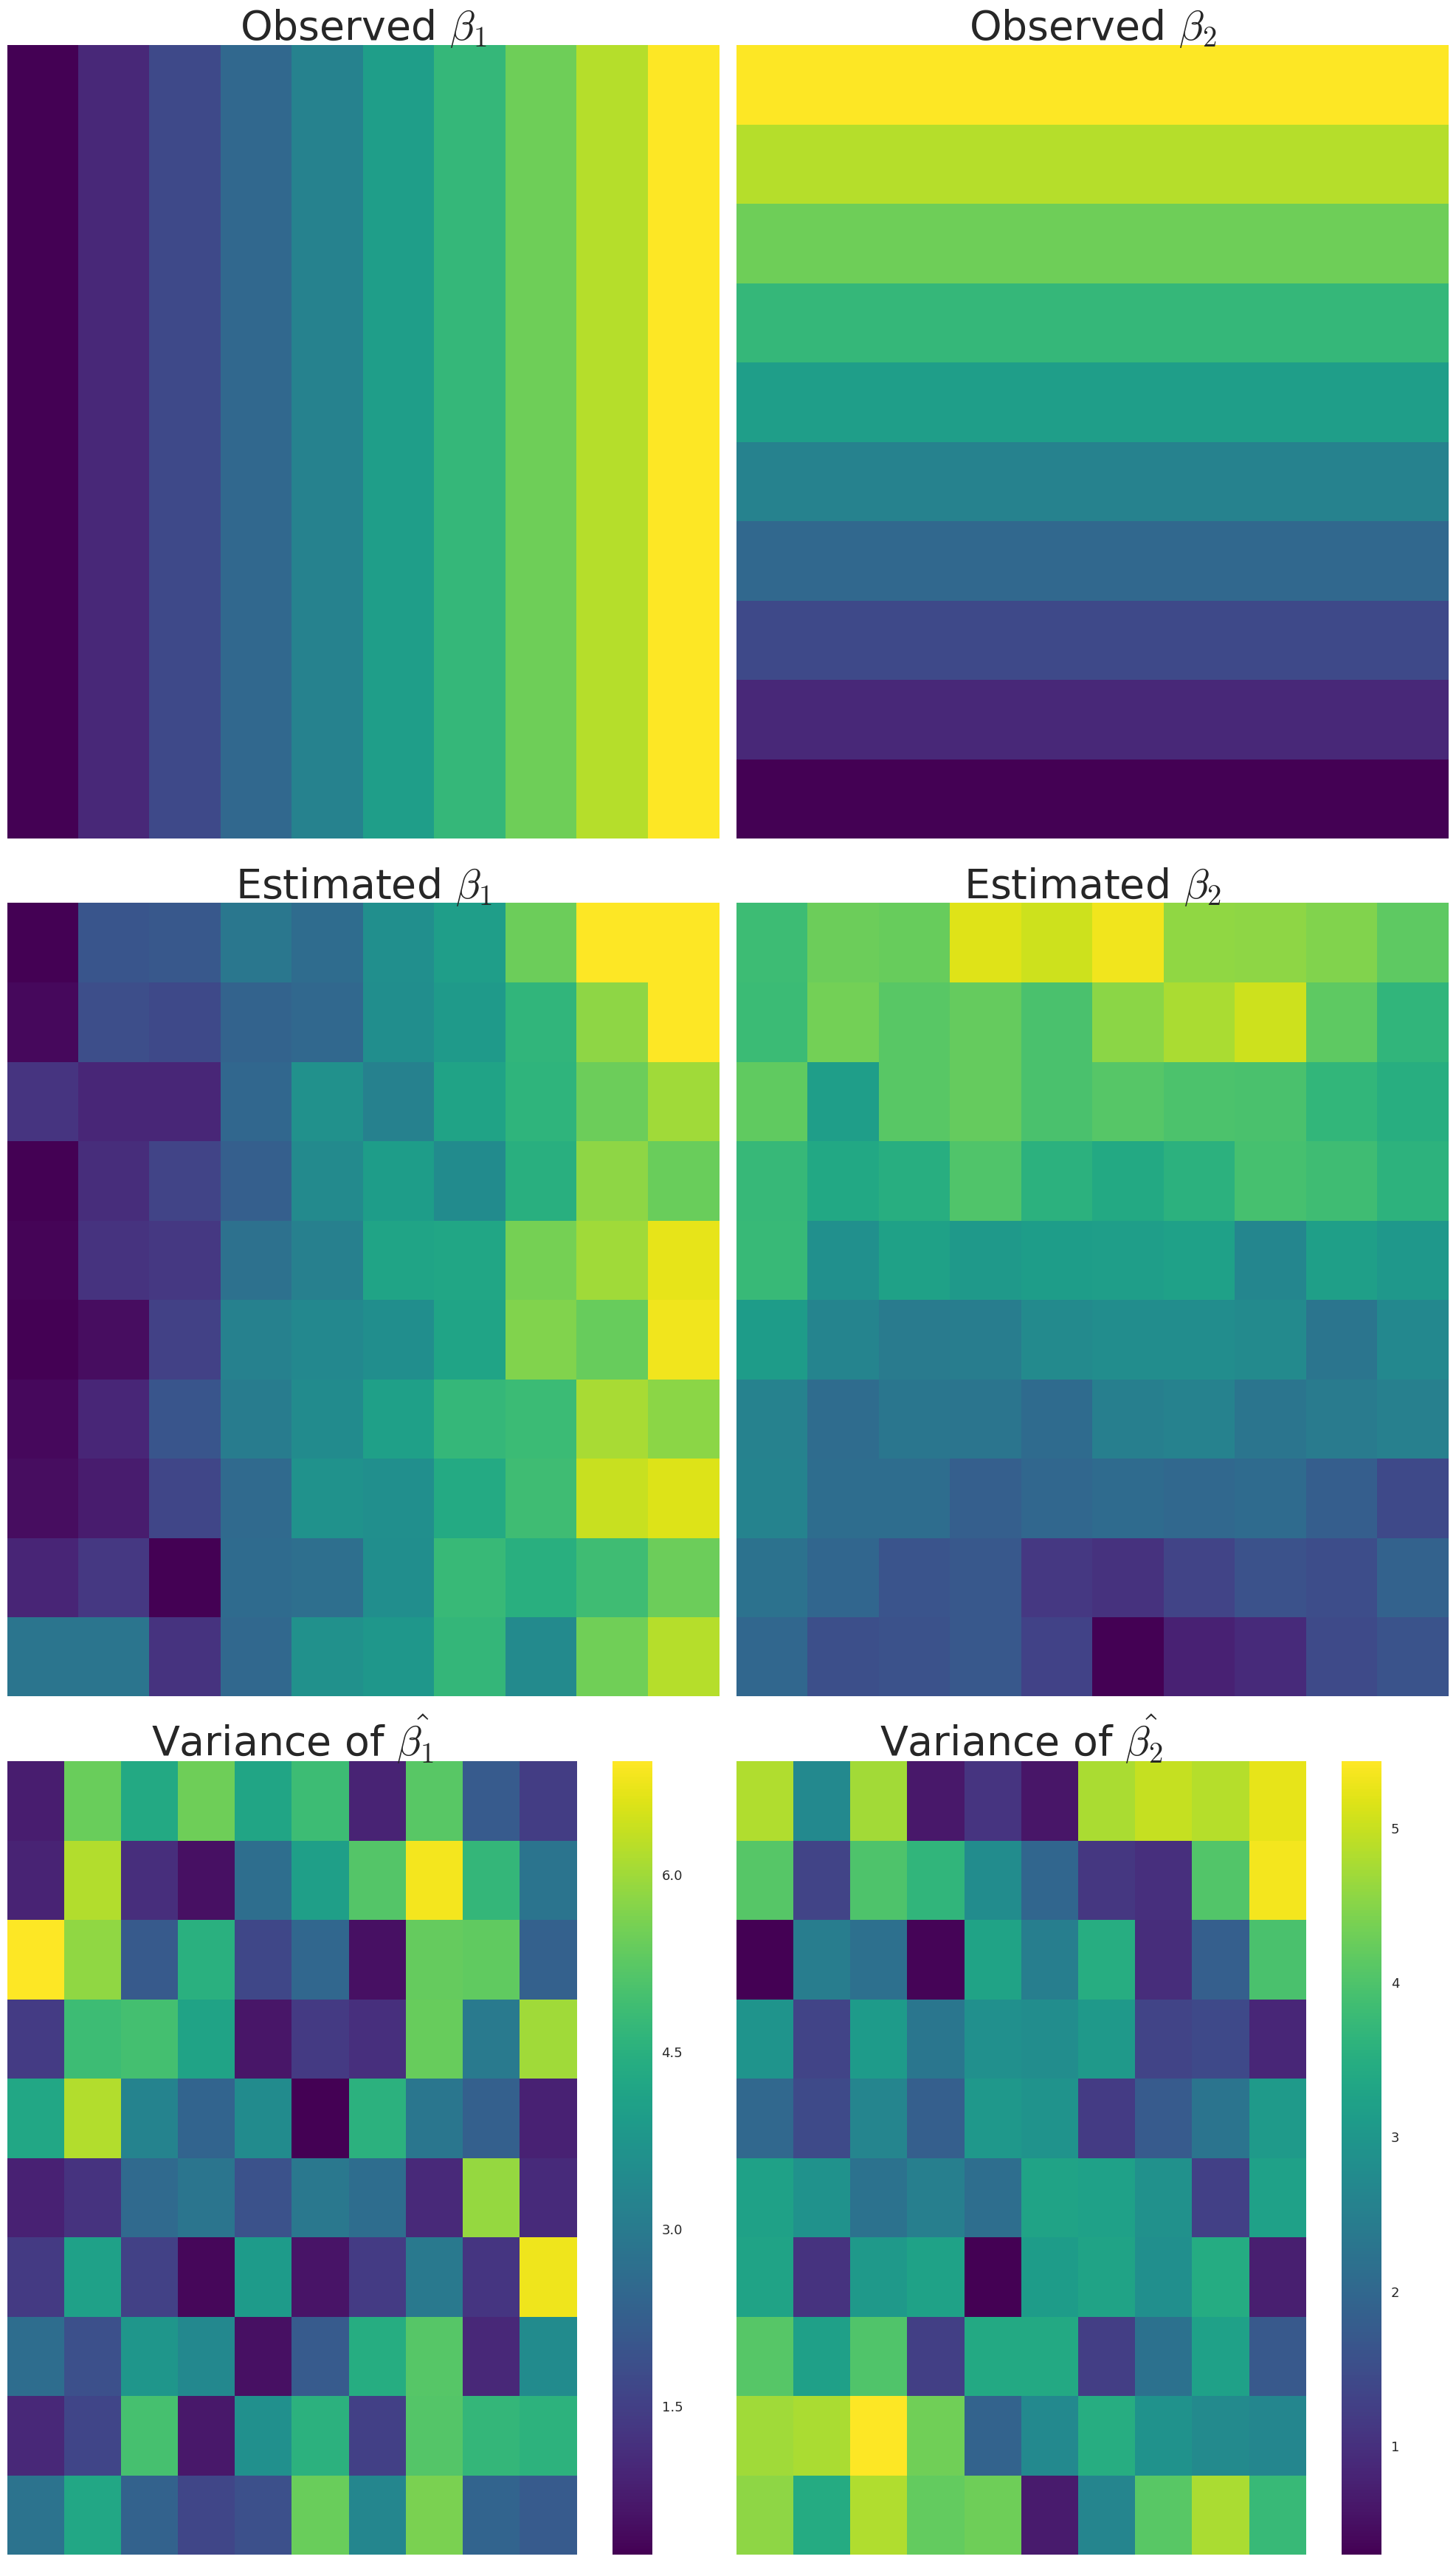

In [26]:
sns.set_context('talk')
fig, ax = plt.subplots(3,2, figsize=(20,35))
sns.heatmap(beta1, ax=ax[0,0], cmap='viridis', vmin=0, vmax=9, cbar=False)
sns.heatmap(beta2, ax=ax[0,1], cmap='viridis', vmin=0, vmax=9, cbar=False)
sns.heatmap(est_b1.mean(axis=1).reshape(10,10), 
            cmap='viridis', vmin=0, vmax=9, ax=ax[1,0], cbar=False)
sns.heatmap(est_b2.mean(axis=1).reshape(10,10), 
            cmap='viridis', vmin=0, vmax=9,  ax=ax[1,1], cbar=False)
sns.heatmap(est_b1.var(axis=1).reshape(10,10), 
            cmap='viridis', ax=ax[2,0], cbar=True)
sns.heatmap(est_b2.var(axis=1).reshape(10,10), 
            cmap='viridis', ax=ax[2,1], cbar=True)
ax[0,0].set_title('Observed $\\beta_1$', fontsize=40)
ax[0,1].set_title('Observed $\\beta_2$', fontsize=40)
ax[1,0].set_title('Estimated $\\beta_1$', fontsize=40)
ax[1,1].set_title('Estimated $\\beta_2$', fontsize=40)
ax[2,0].set_title('Variance of $\\hat{\\beta_1}$', fontsize=40)
ax[2,1].set_title('Variance of $\\hat{\\beta_2}$', fontsize=40)
for i in range(3):
    for j in range(2):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
plt.tight_layout()
plt.savefig('new_small_sim.png')
plt.show()

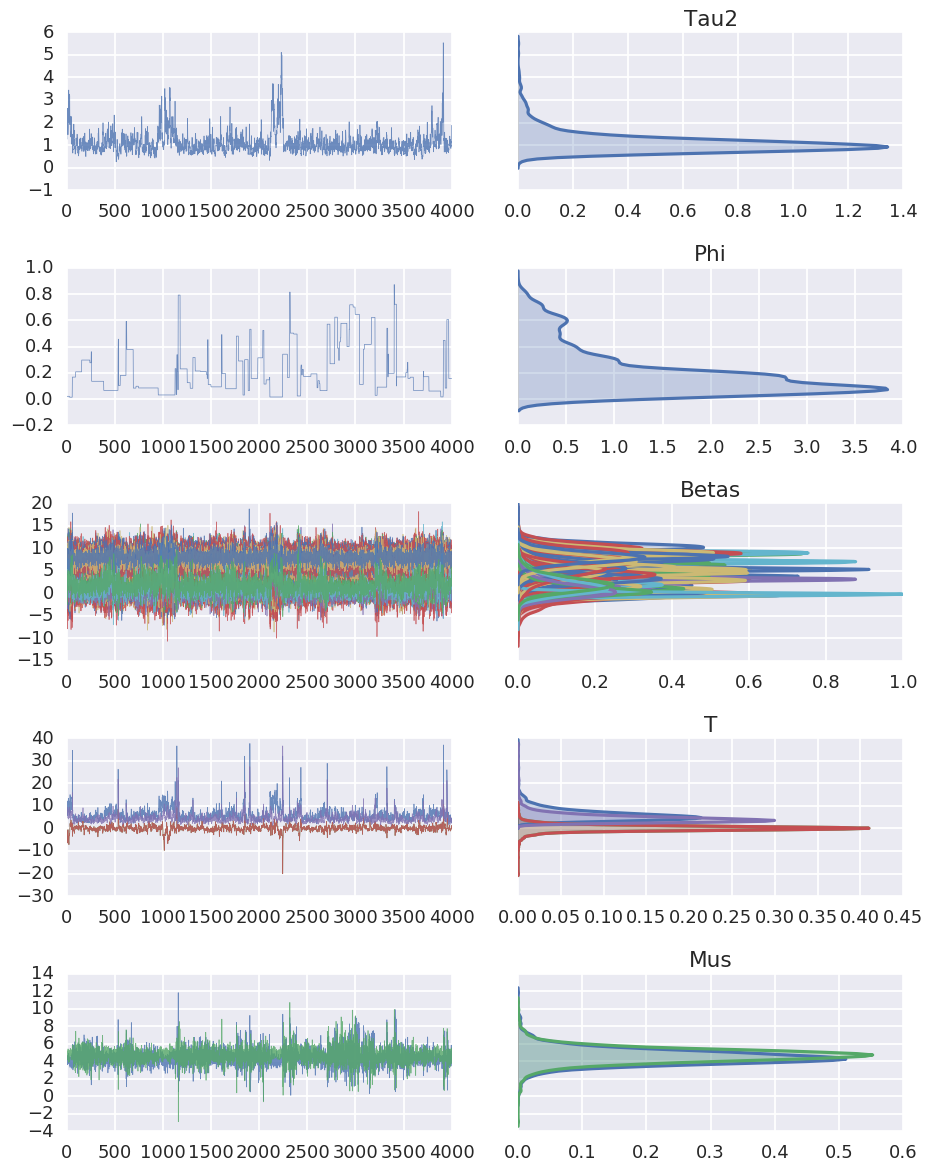

In [32]:
m.trace.plot(burn=1000)
plt.tight_layout()
plt.show()

In [33]:
b1_cube = est_b1.reshape(10,10,5000)
b2_cube = est_b2.reshape(10,10,5000)

In [34]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

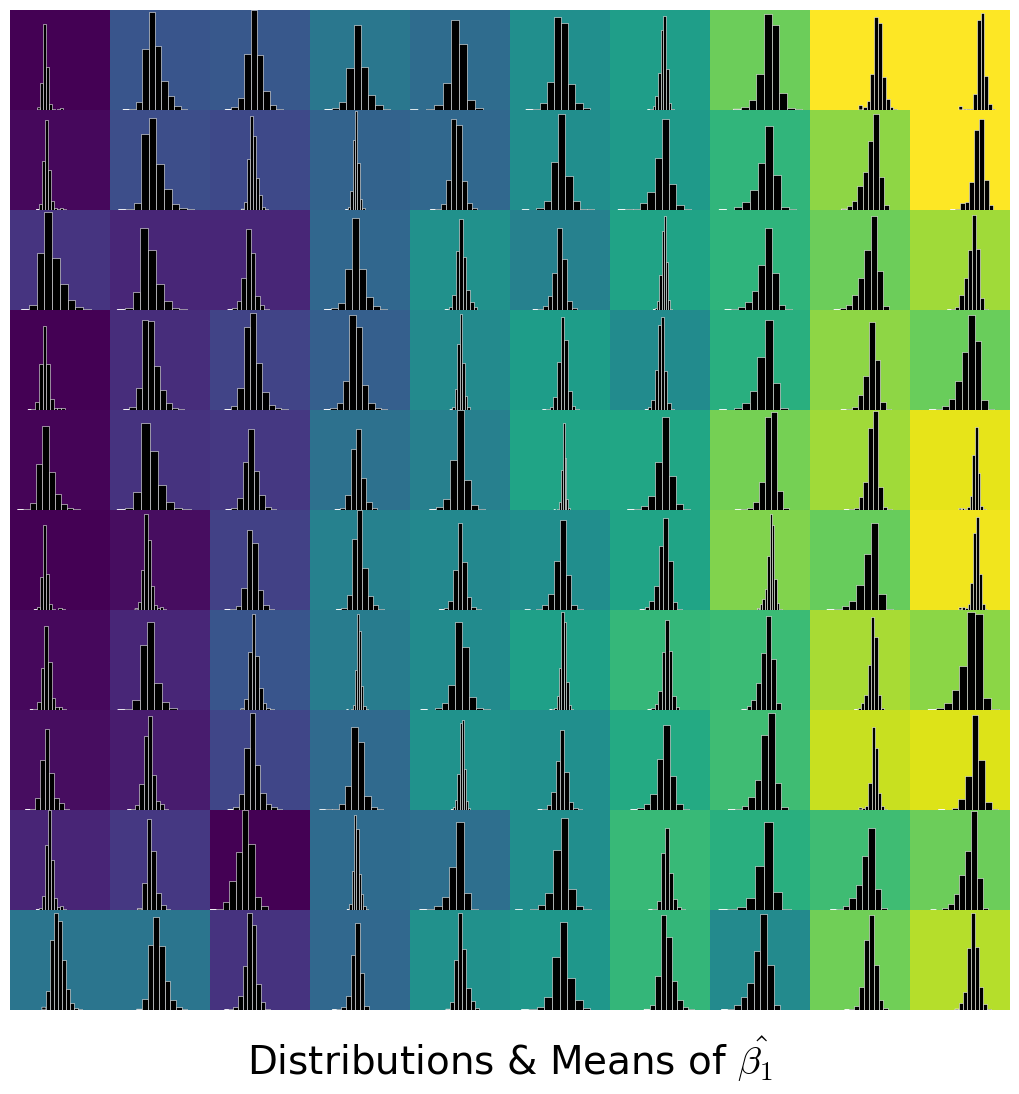

In [35]:
viridis = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=viridis)
fig, ax = plt.subplots(10,10, figsize=(10,10), sharex=True)
for i in range(10):
    for j in range(10):
        cax = ax[i,j]
        cdata = b1_cube[i,j,:]
        cax.hist(cdata, color='k', edgecolor='w')
        cax.set_axis_bgcolor(scalarMap.to_rgba(cdata.mean()))
        cax.set_xticklabels([])
        cax.set_yticklabels([])
        cax.set_xticks([])
        cax.set_yticks([])
plt.tight_layout(pad=0)
st = plt.suptitle('Distributions & Means of $\\hat{\\beta_1}$', color='k', fontsize='28')
st.set_y(-.025)
plt.savefig('10x10_histplot_small_b1.png')
plt.show()

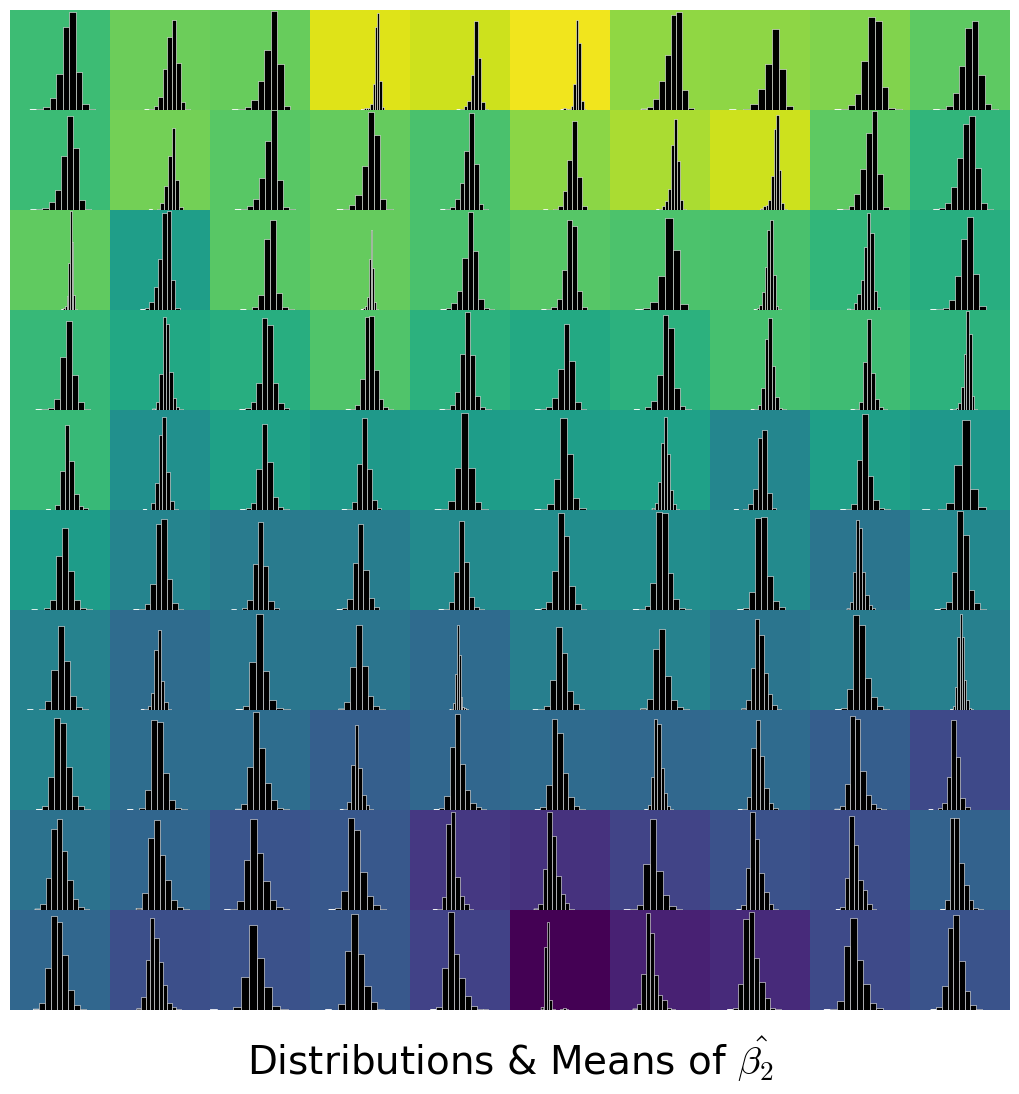

In [36]:
viridis = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=viridis)
fig, ax = plt.subplots(10,10, figsize=(10,10), sharex=True)
for i in range(10):
    for j in range(10):
        cax = ax[i,j]
        cdata = b2_cube[i,j,:]
        cax.hist(cdata, color='k', edgecolor='w')
        cax.set_axis_bgcolor(scalarMap.to_rgba(cdata.mean()))
        cax.set_xticklabels([])
        cax.set_yticklabels([])
        cax.set_xticks([])
        cax.set_yticks([])
plt.tight_layout(pad=0)
st = plt.suptitle('Distributions & Means of $\\hat{\\beta_2}$', color='k', fontsize='28')
st.set_y(-.025)
plt.savefig('10x10_histplot_small_b2.png')
plt.show()

In [47]:
median_nexp = lambda x: np.median(np.exp(-m.state.pwds/x))

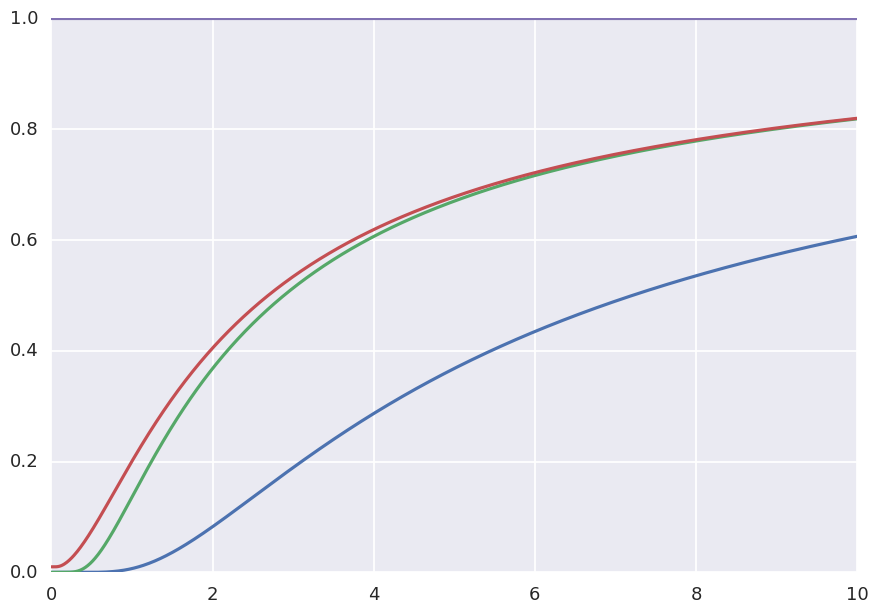

In [55]:
mod=m
plt.plot(np.linspace(.001,10,num=1000), 
         [np.min(np.exp(-mod.state.pwds/x)) for x in np.linspace(.001,2,num=1000)])
plt.plot(np.linspace(.001,10,num=1000), 
         [np.median(np.exp(-mod.state.pwds/x)) for x in np.linspace(.001,2,num=1000)])
plt.plot(np.linspace(.001,10,num=1000), 
         [np.mean(np.exp(-mod.state.pwds/x)) for x in np.linspace(.001,2,num=1000)])
plt.plot(np.linspace(.001,10,num=1000), 
         [np.max(np.exp(-mod.state.pwds/x)) for x in np.linspace(.001,2,num=1000)])

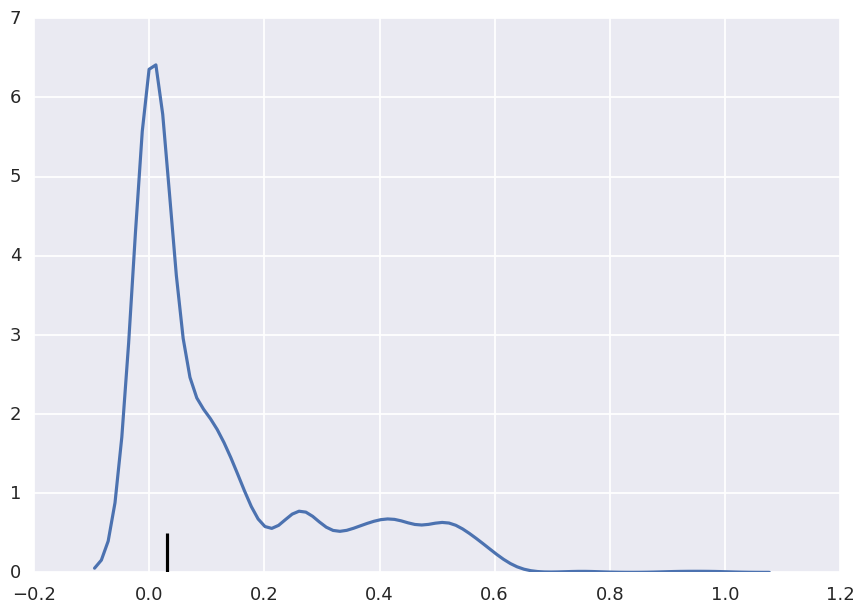

In [53]:
phis = m.trace['Phi']
median_phi = np.median(m.trace['Phi'])
cors = np.asarray([np.median(np.exp(-m.state.pwds/phi)) for phi in phis])
mean_cor = np.median(np.exp(-m.state.pwds/median_phi))
sns.kdeplot(cors)    
plt.vlines(mean_cor, 0,.5)